## 6.3.4 개체명 인식 NER(Named Entity Recognition)

문장 내에 포함된 어떤 단어가 인물, 장소, 날짜 등을 의미하는 단어인지 인식하는 것

챗봇에서는 문장을 정확하게 해석하기 위해 반드시 해야 하는 전처리 과정

예) 내일 부산 날씨 알려줘

    문장의도 분류: 날씨 요청
    
    개체명 인식 결과: 내일 - 날짜 / 부산 - 지역
    
단순한 질문 형태라면 개체명 사전을 구축해 해당 단어들과 매핑되는 개체명을 찾을 수 있으나, 문장 구조가 복잡하거나 문맥에 따라 단어의 의미가 비뀐다면 딥러닝 모델을 활용해야 함

- 단점
    - 신조어나 사전에 포함되지 않은 단어는 처리 불가능함
    - 사람이 직접 사전 데이터를 관리해야 하기 때문에 관리비용이 많이 소요됨
    <br> → 양방향LSTM 모델을 이용해 이러한 단점을 해결 할 수 있음 
    
#### BIO표기법 Beginning, Inside, Outside
- 각 토큰마다 태그를 붙이기 위해 사용
- 두개 이상의 토큰이 하나의 개체를 구성하는 경우가 많을 때 BIO표기법 사용

- 개체명 인식모델을 학습하기 위해서는 토큰 별로 BIO 태그가 달린 데이터셋이 필요
    - 영어의 경우 유명한 데이터셋이 많이 존재하지만 한글의 경우에는 BIO 태그 데이터셋을 구하기 어려움
    - 국립국어원 언어정보나눔터에서 개체명 인식 모델을 위해 말뭉치를 공개
         - 예제사용 데이터셋: HLCT 2016에서 제공하는 말뭉치 데이터 를 수정한 KoreanNERCorpus
         - github.com/machinereading!KoreanNERCorpus
- B는 개체명이 시작되는 단어에 ‘B 개체명’으로 태그되며
<br> I 는 ‘B-개체명’과 연결되는 단어일 때 ‘I-개체명’으로,
<br> O 는 개체명 이외의 모든 토큰에 태그됨

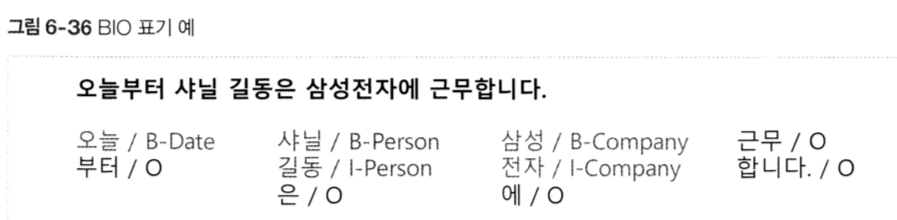

In [2]:
from IPython.display import Image
Image('Data/230629/1.png', width = 600)

#### train.txt 파일

，으로 시작하는 문장 라인은 원본

$로 시작하는 문장 라인은 해당 문장에서 NER 처리된 결과

그 다음 열: 토큰 번호 단어 토큰 품사 태그 BIO 태그

→ 단어 토큰과 BIO 태그 정보만 학습 데이터셋으로 사용함

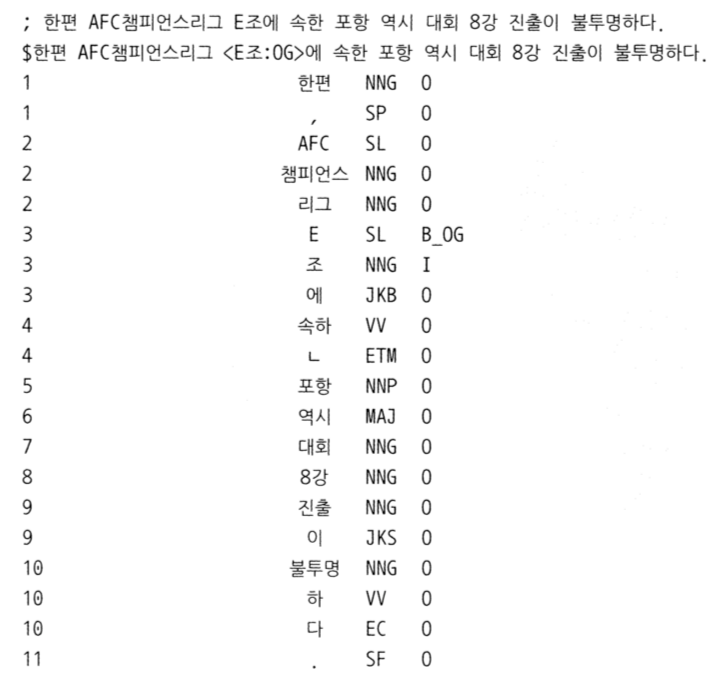

In [4]:
# train.txt파일
Image('Data/230629/2.png', width = 400)

#### 개체명 인식기 모델
단어 토큰을 입력했을 때 출력되는 NER 태그값을 예측하는 문제

B_OG는 단체 (Organization)

B_DT는 날짜

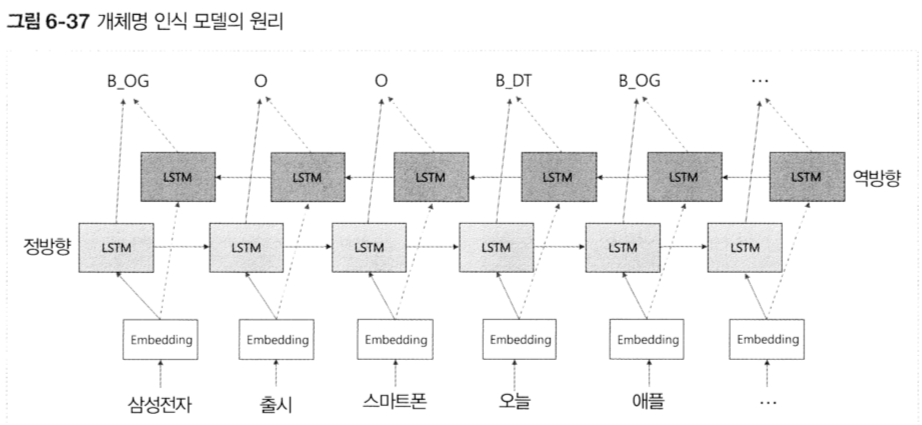

In [6]:
Image('Data/230629/3.png', width = 600)

### [예제8] 양방향 LSTM을 이용한 NER

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from random import random
import tensorflow as tf
from tensorflow.keras import preprocessing
from sklearn.model_selection import train_test_split

# 학습파일 불러오기
def read_file(file_name):
    sents = []
    with open(file_name, 'r', encoding = 'utf-8') as f:
        lines = f.readlines()
        for idx, l in enumerate(lines):
            if l[0] == ';' and lines[idx + 1][0] == '$':
                this_sent = []
            elif l[0] == '$' and lines[idx - 1][0] == ';':
                continue
            elif l[0] == '\n':
                sents.append(this_sent)
            else:
                this_sent.append(tuple(l.split()))
    return sents

# 학습용 말뭉치 데이터 불러오기
corpus = read_file('Data/230629/train.txt')

In [12]:
corpus[:1]

[[('1', '한편', 'NNG', 'O'),
  ('1', ',', 'SP', 'O'),
  ('2', 'AFC', 'SL', 'O'),
  ('2', '챔피언스', 'NNG', 'O'),
  ('2', '리그', 'NNG', 'O'),
  ('3', 'E', 'SL', 'B_OG'),
  ('3', '조', 'NNG', 'I'),
  ('3', '에', 'JKB', 'O'),
  ('4', '속하', 'VV', 'O'),
  ('4', 'ㄴ', 'ETM', 'O'),
  ('5', '포항', 'NNP', 'O'),
  ('6', '역시', 'MAJ', 'O'),
  ('7', '대회', 'NNG', 'O'),
  ('8', '8강', 'NNG', 'O'),
  ('9', '진출', 'NNG', 'O'),
  ('9', '이', 'JKS', 'O'),
  ('10', '불투명', 'NNG', 'O'),
  ('10', '하', 'VV', 'O'),
  ('10', '다', 'EC', 'O'),
  ('11', '.', 'SF', 'O')]]

In [14]:
# 말뭉치 데이터에서 단어와 BIO태그만 불러와서 학습용 데이터셋 생성
sentences , tags = [], []
for t in corpus:
    tagged_sentence = []
    sentence, bio_tag = [], []
    for w in t:
        tagged_sentence.append((w[1], w[3]))
        sentence.append(w[1])
        bio_tag.append(w[3])
    sentences.append(sentence)
    tags.append(bio_tag)
print('샘플 크기: ', len(sentences))
print('\n0번째 샘플 문장 시퀀스: \n', sentences[0])
print('\n0번째 샘플 bio 태그 : \n', tags[0])
print('\n샘플 문장 시퀀스 최대 길이: ', max(len(l) for l in sentences))
print('샘플 문장 시퀀스 평균 길이: ', (sum(map(len, sentences))/len(sentences)))

샘플 크기:  3555

0번째 샘플 문장 시퀀스: 
 ['한편', ',', 'AFC', '챔피언스', '리그', 'E', '조', '에', '속하', 'ㄴ', '포항', '역시', '대회', '8강', '진출', '이', '불투명', '하', '다', '.']

0번째 샘플 bio 태그 : 
 ['O', 'O', 'O', 'O', 'O', 'B_OG', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

샘플 문장 시퀀스 최대 길이:  168
샘플 문장 시퀀스 평균 길이:  34.03909985935302


In [62]:
sum(map(len, sentences)) 

121009

In [45]:
print("sentences 모양 : \n", sentences)

sentences 모양 : 
 [['한편', ',', 'AFC', '챔피언스', '리그', 'E', '조', '에', '속하', 'ㄴ', '포항', '역시', '대회', '8강', '진출', '이', '불투명', '하', '다', '.'], ['2003', '년', '6', '월', '14', '일', '사직', '두산', '전', '이후', '박명환', '에게', '당하', '았', '던', '10', '연패', '사슬', '을', '거의', '5', '년', '만', '에', '끊', '는', '의미', '있', '는', '승리', '이', '었', '다', '.'], ['AP', '통신', '은', '8', '일', '(', '이하', '한국', '시간', ')', '올라주원', ',', '유잉', '을', '비롯', '하', '아', '애드리언', '댄틀리', ',', '팻', '라일리', '감독', ',', '캐시', '러시', '감독', ',', 'TV', '해설가', '딕', '바이텔', ',', '디트로이트', '피스톤스', '의', '구단주', '윌리엄', '데이비드슨', '등', '이', '2008', '명예', '의', '전당', '헌액', '자', '로', '결정', '되', '었', '다고', '보', '아도', '하', '았', '다', '.'], ['(', '개막', '6', '연패', ')', '"', '짐', '릴랜드', '디트로이트', '감독', '은', '메이저리그', '에서', '손꼽히', '는', '명장', '이', '면서', '덕장', '이', '다', '.'], ['역시', '새로', '데려오', 'ㄴ', '돈트렐', '윌리스', '는', '6', '일', '경기', '에서', '삼진', '을', '하나', '도', '잡', '지', '않', '고', '볼넷', '7', '개', '를', '내주', '는', '엽기', '피칭', '을', '하', '었', '다', '.'], ['웽거', '감독', '은', '8', '일

In [46]:
print("bio 태그 모양: \n", tags)

bio 태그 모양: 
 [['O', 'O', 'O', 'O', 'O', 'B_OG', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B_DT', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'B_PS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_DT', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B_OG', 'I', 'O', 'B_DT', 'I', 'O', 'O', 'B_LC', 'O', 'O', 'B_PS', 'O', 'B_PS', 'O', 'O', 'O', 'O', 'B_PS', 'I', 'O', 'B_PS', 'I', 'O', 'O', 'B_PS', 'I', 'O', 'O', 'O', 'O', 'B_PS', 'I', 'O', 'B_OG', 'I', 'O', 'O', 'B_PS', 'I', 'O', 'O', 'B_DT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'B_PS', 'I', 'B_OG', 'O', 'O', 'B_OG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'B_PS', 'I', 'O', 'B_DT', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B_PS', 'O', 'O', 'B_DT', 'I', 'O', 'O', 'B_LC', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

In [19]:
# 토크나이저 정의  
sent_tokenizer = preprocessing.text.Tokenizer(oov_token = 'OOV') 
                    # 첫번째 인덱스에는 OOV 사용
                    # OOV: Out Of Vocabulary 단어사전에 포함되지 않은 단어
                    # Tokenizer에 oov_token을 지정하면 validation / test dataset에 
                    # fit_on_texts 했을 때 OOV token에 대해 1이라는 숫자를 부여함 
sent_tokenizer.fit_on_texts(sentences)
tag_tokenizer = preprocessing.text.Tokenizer(lower = False)   # 태그 정보는 소문자로 변환하지 않음
tag_tokenizer.fit_on_texts(tags)

# 단어 사전 및 태그사전 크기
# 케라스 토크나이저의 정수 인코딩은 인덱스가 1부터 시작, 패딩을 위한 0을 고려하여 +1
vocab_size = len(sent_tokenizer.word_index) + 1     
tag_size = len(tag_tokenizer.word_index) + 1

print("BIO 태그 사전 크기: ", tag_size)
print('단어 사전 크기: ', vocab_size)

BIO 태그 사전 크기:  8
단어 사전 크기:  13834


### Keras Tokenizer ---------------------------------------------------------------------------

In [48]:
from tensorflow.keras.preprocessing.text import Tokenizer

data_list = [
    '오늘 내 주식 올랐다','오늘도 수고했어',' 너는 할 수 있어', '오늘 날씨가 좋다',' 지금처럼만 하면 잘 될거야','넌 너를 좋아해','지금 정말 잘하고 있어','사랑해','오늘 점심 맛있다'
]

# 객체생성
tokenizer = Tokenizer()

#### .fit_on_texts: 글자와 숫자 정보 매핑

In [49]:
tokenizer.fit_on_texts(texts = data_list)    # list타입을 인자로 받음

#### .word_index: 어떤 숫자와 매핑되어 있는지 확인

In [50]:
tokenizer.word_index

{'오늘': 1,
 '있어': 2,
 '내': 3,
 '주식': 4,
 '올랐다': 5,
 '오늘도': 6,
 '수고했어': 7,
 '너는': 8,
 '할': 9,
 '수': 10,
 '날씨가': 11,
 '좋다': 12,
 '지금처럼만': 13,
 '하면': 14,
 '잘': 15,
 '될거야': 16,
 '넌': 17,
 '너를': 18,
 '좋아해': 19,
 '지금': 20,
 '정말': 21,
 '잘하고': 22,
 '사랑해': 23,
 '점심': 24,
 '맛있다': 25}

#### .texts_to_sequences: 각 문장의 정수로 코딩된 리스트 출력

In [51]:
tokenizer.texts_to_sequences(texts = data_list)

[[1, 3, 4, 5],
 [6, 7],
 [8, 9, 10, 2],
 [1, 11, 12],
 [13, 14, 15, 16],
 [17, 18, 19],
 [20, 21, 22, 2],
 [23],
 [1, 24, 25]]

### --------------------------------------------------------------------------------------------------------------------------

In [25]:
sent_tokenizer.word_index

{'OOV': 1,
 '하': 2,
 '.': 3,
 '이': 4,
 '을': 5,
 '는': 6,
 'ㄴ': 7,
 '다': 8,
 '의': 9,
 '에': 10,
 ',': 11,
 '를': 12,
 '은': 13,
 '았': 14,
 '고': 15,
 '(': 16,
 ')': 17,
 '었': 18,
 '가': 19,
 '아': 20,
 '에서': 21,
 '으로': 22,
 '있': 23,
 '일': 24,
 '되': 25,
 '로': 26,
 "'": 27,
 '어': 28,
 'ㄹ': 29,
 '과': 30,
 '들': 31,
 '1': 32,
 '2': 33,
 '도': 34,
 '와': 35,
 '-': 36,
 '등': 37,
 '것': 38,
 '지': 39,
 '3': 40,
 'ㄴ다': 41,
 '년': 42,
 '"': 43,
 '월': 44,
 '%': 45,
 '만': 46,
 '적': 47,
 '기': 48,
 '게': 49,
 '4': 50,
 '시': 51,
 '원': 52,
 '며': 53,
 '수': 54,
 '5': 55,
 '밝히': 56,
 '대하': 57,
 '주': 58,
 '말': 59,
 '다고': 60,
 '면': 61,
 '던': 62,
 '위하': 63,
 '전': 64,
 '오': 65,
 '까지': 66,
 '10': 67,
 '대': 68,
 '지나': 69,
 '부터': 70,
 '7': 71,
 ':': 72,
 '6': 73,
 '한국': 74,
 '받': 75,
 '않': 76,
 '명': 77,
 '경기': 78,
 '대표': 79,
 '보': 80,
 '지만': 81,
 '라고': 82,
 '시장': 83,
 '에게': 84,
 '따르': 85,
 '9': 86,
 '8': 87,
 '개': 88,
 '내': 89,
 '중': 90,
 '서울': 91,
 '‘': 92,
 '분': 93,
 '억': 94,
 '회': 95,
 '’': 96,
 '감독': 97,
 '의원': 98,
 '기록'

In [26]:
tag_tokenizer.word_index

{'O': 1, 'I': 2, 'B_OG': 3, 'B_PS': 4, 'B_DT': 5, 'B_LC': 6, 'B_TI': 7}

In [64]:
len(sent_tokenizer.word_index), len(tag_tokenizer.word_index)

(13833, 7)

In [27]:
# 학습용 단어 시퀀스 생성
x_train = sent_tokenizer.texts_to_sequences(sentences)
y_train = tag_tokenizer.texts_to_sequences(tags)
print(x_train[0])
print(y_train[0])

[183, 11, 4276, 884, 162, 931, 402, 10, 2608, 7, 1516, 608, 145, 1361, 414, 4, 6347, 2, 8, 3]
[1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [28]:
# index to word / index to NER 정의
index_to_word = sent_tokenizer.index_word    # 시퀀스 인덱스를 단어로 변환하기 위해 사용
index_to_ner = tag_tokenizer.index_word    # 시퀀스 인덱스를 NER로 변환하기 위해 사용
index_to_ner[0] = 'PAD'

# 시퀀스 패딩 처리
max_len = 40
x_train = preprocessing.sequence.pad_sequences(x_train, padding = 'post', maxlen = max_len)
y_train = preprocessing.sequence.pad_sequences(y_train, padding = 'post', maxlen = max_len)

#### 시퀀스 패딩 처리
keras.preprocessing.sequence.pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)

- sequences: 리스트의 리스트로, 각 성분이 시퀀스
- maxlen: 정수, 모든 시퀀스의 최대 길이
- dtype: 출력 시퀀스의 자료형. 가변적 길이의 문자열로 시퀀스를 패딩하려면 object를 사용
- padding: 'pre' 혹은 'post': 각 시퀀스의 처음 혹은 끝을 패딩
- truncating: 'pre' 혹은 'post': maxlen보다 큰 시퀀스의 처음 혹은 끝의 값들을 제거
- value: 부동소수점 혹은 문자열, 패딩할 값

### Keras 패딩처리 -----------------------------------------------------------------------------
- 각 문장 길이가 다르면 병렬 연산이 어려우므로 패딩을 통해 고정된 길이를 맞춰줌

#### pad_sequences 

In [56]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

data = [ [1,2,3], [4,5], [6,7,8,9,10,11] ]
data_padded = pad_sequences(sequences = data)
data_padded

array([[ 0,  0,  0,  1,  2,  3],
       [ 0,  0,  0,  0,  4,  5],
       [ 6,  7,  8,  9, 10, 11]])

#### padding 방향 설정

In [57]:
pad_sequences(sequences = data, padding = 'post')  # default : padding = 'pre'

array([[ 1,  2,  3,  0,  0,  0],
       [ 4,  5,  0,  0,  0,  0],
       [ 6,  7,  8,  9, 10, 11]])

#### value 적용

In [58]:
pad_sequences(sequences = data, value = 9999)

array([[9999, 9999, 9999,    1,    2,    3],
       [9999, 9999, 9999, 9999,    4,    5],
       [   6,    7,    8,    9,   10,   11]])

#### maxlen 적용
- 패딩 기준을 제일 긴 문장 기준이 아니라 임의로 변경 가능

In [59]:
pad_sequences(sequences = data, maxlen = 10)  

array([[ 0,  0,  0,  0,  0,  0,  0,  1,  2,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4,  5],
       [ 0,  0,  0,  0,  6,  7,  8,  9, 10, 11]])

#### truncating 적용
- truncating = 'post' 적용시 뒤에서부터 truncate (디폴트는 'pre')

In [60]:
pad_sequences(sequences = data, maxlen = 3, truncating = 'post')  

array([[1, 2, 3],
       [0, 4, 5],
       [6, 7, 8]])

### ---------------------------------------------------------------------------------------------------

In [ ]:
# 학습 데이터와 테스트 데이터를 8:2 비율로 분리
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 2, random_state=0)

In [30]:
# 시퀀스 인덱스를 단어로 변환하기 위해 사용
sent_tokenizer.index_word

{1: 'OOV',
 2: '하',
 3: '.',
 4: '이',
 5: '을',
 6: '는',
 7: 'ㄴ',
 8: '다',
 9: '의',
 10: '에',
 11: ',',
 12: '를',
 13: '은',
 14: '았',
 15: '고',
 16: '(',
 17: ')',
 18: '었',
 19: '가',
 20: '아',
 21: '에서',
 22: '으로',
 23: '있',
 24: '일',
 25: '되',
 26: '로',
 27: "'",
 28: '어',
 29: 'ㄹ',
 30: '과',
 31: '들',
 32: '1',
 33: '2',
 34: '도',
 35: '와',
 36: '-',
 37: '등',
 38: '것',
 39: '지',
 40: '3',
 41: 'ㄴ다',
 42: '년',
 43: '"',
 44: '월',
 45: '%',
 46: '만',
 47: '적',
 48: '기',
 49: '게',
 50: '4',
 51: '시',
 52: '원',
 53: '며',
 54: '수',
 55: '5',
 56: '밝히',
 57: '대하',
 58: '주',
 59: '말',
 60: '다고',
 61: '면',
 62: '던',
 63: '위하',
 64: '전',
 65: '오',
 66: '까지',
 67: '10',
 68: '대',
 69: '지나',
 70: '부터',
 71: '7',
 72: ':',
 73: '6',
 74: '한국',
 75: '받',
 76: '않',
 77: '명',
 78: '경기',
 79: '대표',
 80: '보',
 81: '지만',
 82: '라고',
 83: '시장',
 84: '에게',
 85: '따르',
 86: '9',
 87: '8',
 88: '개',
 89: '내',
 90: '중',
 91: '서울',
 92: '‘',
 93: '분',
 94: '억',
 95: '회',
 96: '’',
 97: '감독',
 98: '의원',
 99: 

In [31]:
# 시퀀스 인덱스를 NER로 변환하기 위해 사용
tag_tokenizer.index_word

{1: 'O',
 2: 'I',
 3: 'B_OG',
 4: 'B_PS',
 5: 'B_DT',
 6: 'B_LC',
 7: 'B_TI',
 0: 'PAD'}

In [32]:
print('학습 샘플 시퀀스 형상: ', x_train.shape)
print('학습 샘플 레이블 형상: ', y_train.shape)
print('테스트 샘플 시퀀스 형상: ', x_test.shape)
print('테스트 샘플 레이블 형상: ', y_test.shape)

학습 샘플 시퀀스 형상:  (3553, 40)
학습 샘플 레이블 형상:  (3553, 40)
테스트 샘플 시퀀스 형상:  (2, 40)
테스트 샘플 레이블 형상:  (2, 40)


In [43]:
tag_size

8

In [33]:
# 출력 데이터를 원핫 인코딩
y_train = tf.keras.utils.to_categorical(y_train, num_classes=tag_size)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=tag_size)
print('학습 샘플 시퀀스 형상: ', x_train.shape)
print('학습 샘플 레이블 형상: ', y_train.shape)
print('테스트 샘플 시퀀스 형상: ', x_test.shape)
print('테스트 샘플 레이블 형상: ', y_test.shape)

학습 샘플 시퀀스 형상:  (3553, 40)
학습 샘플 레이블 형상:  (3553, 40, 8)
테스트 샘플 시퀀스 형상:  (2, 40)
테스트 샘플 레이블 형상:  (2, 40, 8)


In [34]:
# 모델 정의(Bi-LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, LSTM, TimeDistributed, Embedding, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = 30, input_length = max_len, mask_zero = True))
model.add(Bidirectional(LSTM(200, return_sequences = True, dropout = 0.40, recurrent_dropout = 0.25)))
model.add(TimeDistributed(Dense(tag_size, activation = 'softmax')))
model.compile(optimizer = Adam(0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])
        # 학습률 기본값 : 0.01
model.fit(x_train, y_train, epochs = 10, batch_size = 128)

print('평가 결과: ', model.evaluate(x_test, y_test)[1])

Epoch 1/10
28/28 [==============================] - 13s 312ms/step - loss: 0.6546 - accuracy: 0.8417
Epoch 2/10
28/28 [==============================] - 9s 310ms/step - loss: 0.2831 - accuracy: 0.9083
Epoch 3/10
28/28 [==============================] - 9s 334ms/step - loss: 0.1874 - accuracy: 0.9355
Epoch 4/10
28/28 [==============================] - 9s 326ms/step - loss: 0.1353 - accuracy: 0.9567
Epoch 5/10
28/28 [==============================] - 9s 309ms/step - loss: 0.0939 - accuracy: 0.9708
Epoch 6/10
28/28 [==============================] - 9s 307ms/step - loss: 0.0679 - accuracy: 0.9785
Epoch 7/10
28/28 [==============================] - 9s 312ms/step - loss: 0.0515 - accuracy: 0.9838
Epoch 8/10
28/28 [==============================] - 8s 303ms/step - loss: 0.0408 - accuracy: 0.9866
Epoch 9/10
28/28 [==============================] - 9s 320ms/step - loss: 0.0337 - accuracy: 0.9890
Epoch 10/10
1/1 [==============================] - 1s 781ms/step - loss: 0.0278 - accuracy: 0.9848


In [35]:
# 시퀀스를 NER태그로 변환
def sequences_to_tag(sequences):
    result = []
    for sequence in sequences:
        temp = []
        for pred in sequence:
            pred_index = np.argmax(pred)
            temp.append(index_to_ner[pred_index].replace("PAD", "0"))
        result.append(temp)
    return result    

# 텍스트 데이터셋의 NER 예측
y_predicted = model.predict(x_test)   # (711, 40) >> model >> (711, 40, 8)
pred_tags = sequences_to_tag(y_predicted)    # 예측된 NER
test_tags = sequences_to_tag(y_test)    # 실제 NER

1/1 [==============================] - 0s 403ms/step


In [38]:
y_predicted

array([[[2.24298742e-06, 6.10947609e-04, 7.70365237e-04, 4.59180534e-04,
         3.16667625e-09, 9.97768998e-01, 3.33403545e-06, 3.84949613e-04],
        [7.53104132e-07, 8.67667026e-04, 9.99109328e-01, 5.93024788e-06,
         7.78389406e-08, 1.28888132e-05, 2.64860205e-06, 7.21921708e-07],
        [1.39468227e-07, 8.19009962e-04, 9.97753680e-01, 2.22216349e-05,
         2.92828850e-09, 1.40310719e-03, 1.89739637e-06, 2.50323779e-08],
        [6.07489383e-08, 4.50025022e-04, 9.99370635e-01, 2.40198759e-08,
         1.89443600e-12, 1.38214396e-04, 3.76258031e-05, 3.35504797e-06],
        [9.92649802e-06, 9.43023205e-01, 4.99423072e-02, 5.78083377e-03,
         1.99960967e-04, 2.47576809e-05, 8.83101660e-04, 1.35850642e-04],
        [2.10661574e-06, 9.28614676e-01, 7.11829960e-02, 1.14292037e-04,
         2.02365783e-07, 1.96872770e-05, 4.35793590e-05, 2.23729949e-05],
        [3.74571174e-09, 8.84980142e-01, 1.15019672e-01, 9.56734025e-10,
         3.08129700e-09, 3.70660902e-09, 3.46

In [39]:
pred_tags

[['B_DT',
  'I',
  'I',
  'I',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['B_PS',
  'B_OG',
  'I',
  'I',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'I',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']]

In [40]:
test_tags

[['B_DT',
  'I',
  'I',
  'I',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0'],
 ['B_PS',
  'B_OG',
  'I',
  'I',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  '0',
  '0']]

#### F1 Score
- F1 Score는 Precision과 Recall의 조화평균으로 주로 분류 클래스 간의 데이터가 불균형이 심각할때 사용

$$ F1 score = 2 × \frac{precision × recall}{precision + recall}$$

- precision: True라고 분류한 것 중 실제로 True인 것의 비율 (Positive 정답률)
<br> recall: 실제 True인 것 중에서 True라고 예측한 비율 (Hit rate)
- 높을수록 좋은 모델임

In [41]:
# F1스코어 계산
from seqeval.metrics import f1_score, classification_report
# from sklearn.metrics import f1_score, classification_report
print(classification_report(test_tags, pred_tags))
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

              precision    recall  f1-score   support

           _       0.67      1.00      0.80         2
         _DT       1.00      1.00      1.00         1
         _OG       1.00      1.00      1.00         1
         _PS       1.00      1.00      1.00         1

   micro avg       0.83      1.00      0.91         5
   macro avg       0.92      1.00      0.95         5
weighted avg       0.87      1.00      0.92         5

F1-score: 90.9%


c:\python38\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: B_DT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\python38\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\python38\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: B_PS seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\python38\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: B_OG seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [42]:
# 새로운 유형의 문장 NER 예측
word_to_index = sent_tokenizer.word_index
new_sentence = '삼성전자 출시 스마트폰 오늘 애플 도전장 내밀다.'.split()
new_x = []
for w in new_sentence:
    try:
        new_x.append(word_to_index.get(w, 1))
    except KeyError:
        # 모르는 단어의 경우 OOV
        new_x.append(word_to_index['OOV'])

print('새로운 유형의 시퀀스: ', new_x)
new_padded_seqs = preprocessing.sequence.pad_sequences([new_x], padding = 'post', value = 0, maxlen = max_len)

# NER 예측
p = model.predict(np.array([new_padded_seqs[0]]))
p = np.argmax(p, axis = -1)   # 예측된 NER 인덱스값 추출

print('{:10} {:5}'.format('단어','예측된 NER'))
print("-"*50)
for w, pred in zip(new_sentence, p[0]):
    print('{:10} {:5}'.format(w, index_to_ner[pred]))

새로운 유형의 시퀀스:  [531, 307, 1476, 286, 1507, 6766, 1]
1/1 [==============================] - 0s 18ms/step
단어         예측된 NER
--------------------------------------------------
삼성전자       B_OG 
출시         O    
스마트폰       O    
오늘         B_DT 
애플         B_OG 
도전장        O    
내밀다.       O    
